In [1]:
import psycopg2, psycopg2.extensions, psycopg2.extras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

%matplotlib inline

# Uvoz podatkov

In [2]:
################
#priklop na bazo
psycopg2.extensions.register_type(psycopg2.extensions.UNICODE) # se znebimo problemov s sumniki
baza = psycopg2.connect(database='sem2018_metodj', host='baza.fmf.uni-lj.si', user='metodj', password='gilbertarenas0')
baza.set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_AUTOCOMMIT) 
cur = baza.cursor(cursor_factory=psycopg2.extras.DictCursor)

In [4]:
################
#test priklopa na bazo
def test(tmp):
    cur.execute('''
                    SELECT * FROM dftest 
                ''', [tmp])
    return (cur.fetchall())

#print(test('')[0])

In [5]:
################
#preprocessing
data = test('')
baza = []
for i in range(len(data)):
    tmp = dict()
    tmp['ime'] = data[i][0]
    tmp['spol'] =  data[i][1]
    tmp['zveznaDržava'] = data[i][2]
    tmp['višina'] = data[i][3]
    tmp['plača'] = data[i][4]
    baza.append(tmp)

data = pd.DataFrame(baza)
data['spol'] = np.where(data['spol']=='Male', 'M', 'Ž')
data.head()

,ime,plača,spol,višina,zveznaDržava
0,Montague Goard,3650,M,1.73,TX
1,Danica Di Biaggi,4207,Ž,1.46,SC
2,Patsy Byre,3608,Ž,1.76,NV
3,Tobit Rolling,3490,M,1.74,OR
4,Herculie Dally,2294,M,1.89,MN


# Laplacov mehanizem za numerične podatke (perturbacija podatkovne baze)

In [30]:
#izracun diametra (preveri veljavnost!!)
def diameter(data):
    return max(abs(x[0] - x[1]) for x in zip(data[1:], data))

In [149]:
#nastavi 'plača' ali 'višina'
podatki= list(float(i) for i in data['plača'])
epsilon = 1
delta = 0.5
b = diameter(podatki)/(epsilon - np.log(1-delta))

df_podatki = map(lambda elem: round(elem + np.random.laplace(0,b),2), podatki)

In [150]:
#osnovna primerjava
print(podatki[:5])
print(df_podatki[:5])
print(diameter(podatki))
print(b)

[3650.0, 4207.0, 3608.0, 3490.0, 2294.0]
[3733.51, 6599.02, 4698.46, -1064.67, -1893.68]
2868.0
1693.88700104


In [151]:
#poračunanih nekaj osnovnih statistik za primerjavo
print(sum(podatki)/len(podatki))
print(sum(df_podatki)/len(df_podatki))
print(max(podatki), min(podatki))
print(max(df_podatki), min(df_podatki))

#poglej še povprečje ženski moški

2995.072
3151.22206
(4500.0, 1504.0)
(14881.6, -8081.19)


In [152]:
#spodnja meja za največjo napako (izrek 5.3)
spodnja_meja = (1-delta)*diameter(podatki)/(2*(1+np.exp(epsilon)))
spodnja_meja

192.8309991222865

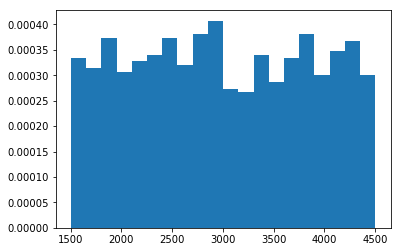

In [55]:
plt.hist(podatki, normed=True, bins=20);

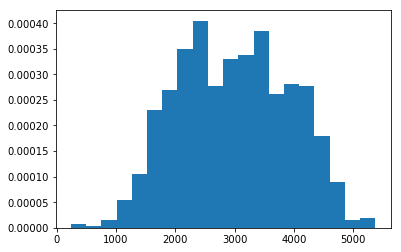

In [56]:
plt.hist(df_podatki, normed=True, bins=20);

# Mehanizem za diskretne podatke (perturbacija podatkovne baze)

In [140]:
epsilon2 = 2
delta2 = 0.5

In [141]:
#zvezne države

m = 47 # |D| = 48, torej imamo v bazi 48 različnih zveznih držav
p = (1 - delta2) / (m + np.exp(epsilon2))

print(p)
print(1-p*m)

drzave = list(str(i) for i in data['zveznaDržava'])
seznam_drzav = list(set(drzave))

df_drzave = []
for i in range(len(drzave)):
    if np.random.uniform(0,1) < (1-p*m):
        df_drzave.append(drzave[i])
    else:
        tmp = list(seznam_drzav)
        tmp.remove(drzave[i])
        df_drzave.append(random.choice(tmp))

0.00919302587437
0.567927783905


In [142]:
#osnovna primerjava
print(drzave[:10])
print(df_drzave[:10])

['TX', 'SC', 'NV', 'OR', 'MN', 'MO', 'WA', 'NC', 'UT', 'MN']
['TX', 'SC', 'NV', 'OR', 'MN', 'MO', 'IL', 'NC', 'UT', 'MN']


In [143]:
#poračunanih nekaj osnovnih statistik za primerjavo
def most_common(lst):
    return max(set(lst), key=lst.count)

print(most_common(drzave))
print(most_common(df_drzave))

TX
TX


In [144]:
#spodnja meja za največjo napako (izrek 5.4)
spodnja_meja = (1-delta2)*m/(m+np.exp(epsilon2))
spodnja_meja

0.43207221609536328

In [145]:
counter = 0
for i in range(len(drzave)):
    if drzave[i] != df_drzave[i]:
        counter += 1;

print(counter)

398


In [146]:
#spol (enostaven primer, naš odzivni mehanizem bo kar Bernoullijeva slučanja spremenljivka)

m = 1 # |D| = 2, moški in ženski spol
p = (1 - delta2) / (m + np.exp(epsilon2))

print(p)
print(1-p*m)

0.0596014610111
0.940398538989


# Primer funkcijskih podatkov - kernel density estimation

In [91]:
seznam = np.concatenate([np.random.normal(1, 1, [100]), np.random.normal(5, 1, [100])])

C:\Users\Uporabnik\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: covariance is not positive-semidefinite.


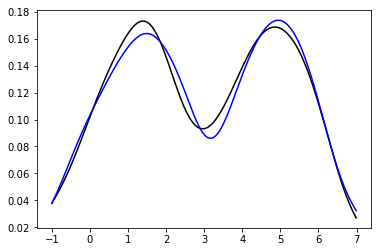

In [98]:
def f(x, h=0.6,d=1):
    return (1/(len(seznam)*(2*np.pi*h**2)**(d*0.5)))*sum(map(lambda elem: np.exp(-((elem-x)**2)/(2*h**2)),seznam))

def koef (epsilon, delta, n , d, h):
    return np.sqrt(np.log(2/delta))*(1/(epsilon*n*(2*np.pi*h**2)**(d/2)))

def gaussKernel(x,y,h):
    return np.exp(-((x-y)**2)/(2*h**2))

def gaussProcess(from_index, to_index, h, start, m):
    t = np.linspace(from_index, to_index, m)
    sigma = np.zeros((m,m))
    for i in range(m):
        for j in range(m):
            sigma[i][j] = gaussKernel(t[i],t[j],h)
    trajektorija = np.random.multivariate_normal(np.zeros(m),sigma)
    final = [x - trajektorija[0] + start for x in trajektorija]
    return final

t1 = np.arange(-1, 7,0.01)

tocke_gauss = gaussProcess(-1,7,0.6,0,800)
tocke = map(lambda elem: f(elem),list(t1))
koeficient = koef(1,0.1,200,1,0.6)
tocke_final = [x+koeficient*y for x,y in zip(tocke, tocke_gauss)]



plt.plot(t1, f(t1), 'k')
plt.plot(t1, tocke_final, 'b')

plt.show()